In [1]:
import os
if not os.path.exists('open-images-bus-trucks'):
    !pip install -q torch_snippets
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

Cloning into 'ssd-utils'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), 13.63 KiB | 2.27 MiB/s, done.
/home/avikus/Projects/Inference_spike/SSD_tutorial/ssd-utils


In [2]:
from torch_snippets import *
DATA_ROOT = '../open-images-bus-trucks/'
IMAGE_ROOT = f'{DATA_ROOT}/images'
DF_RAW = df = pd.read_csv(f'{DATA_ROOT}/df.csv')

df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
import glob
import collections, os, torch
from PIL import Image
from torchvision import transforms

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
    
class OpenDataset(torch.utils.data.Dataset):
    w, h = 300, 300
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
        logger.info(f'{len(self)} items loaded')
        
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        return img, boxes, labels

    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item
            img = preprocess_image(img)[None]
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device)
        return images, boxes, labels
    
    def __len__(self):
        return len(self.image_infos)

In [8]:
from sklearn.model_selection import train_test_split

trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

2022-01-02 15:13:06.561 | INFO     | __main__:__init__:27 - 13702 items loaded
2022-01-02 15:13:06.585 | INFO     | __main__:__init__:27 - 1523 items loaded


In [9]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss
    
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [10]:
from model import SSD300, MultiBoxLoss
from detect import *

In [11]:
n_epochs = 3

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 5


Loaded base model.



/home/avikus/Projects/NAS_detection_boat/.venv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [12]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss = train_batch(inputs, model, criterion, optimizer)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), end='\r')

/home/avikus/Projects/NAS_detection_boat/.venv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


EPOCH: 3.000	val_loss: 2.090	(1226.31s - 0.00s remaining)))))

In [13]:
image_paths = Glob(f'{DATA_ROOT}/images/*')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

2022-01-02 15:33:39.648 | INFO     | torch_snippets.paths:inner:27 - 15225 files found at ../open-images-bus-trucks//images/*


2022-01-02 15:35:37.762 | INFO     | torch_snippets.paths:inner:27 - 15225 files found at ../open-images-bus-trucks//images/*


[[75, 62, 198, 143]] ['Bus @ 1.00']


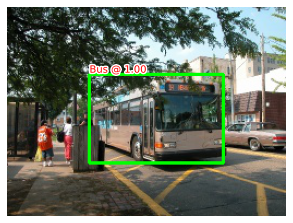

[[0, 0, 256, 192]] ['background @ 0.00']


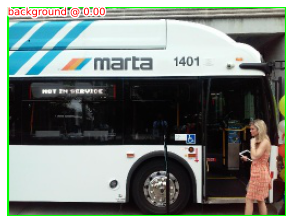

[[44, 39, 214, 152]] ['Truck @ 1.00']


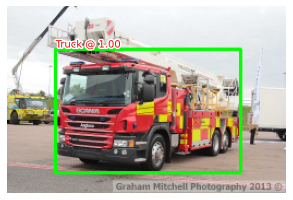

[[84, 48, 195, 121]] ['Truck @ 1.00']


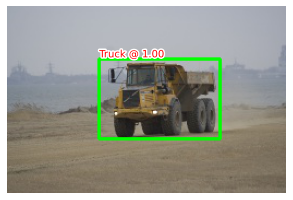

[[17, -3, 148, 251]] ['Bus @ 0.98']


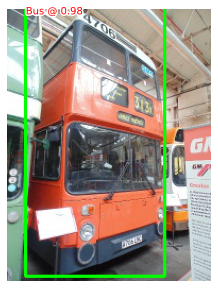

In [18]:
image_paths = Glob(f'{DATA_ROOT}/images/*')

for _ in range(5):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10)